# Calculating Star Formation Rates with Photometry
In this activity, you will determine the star formation rate (SFR) of the nucleus and on star forming region in the Fireworks Galaxy, or NGC6946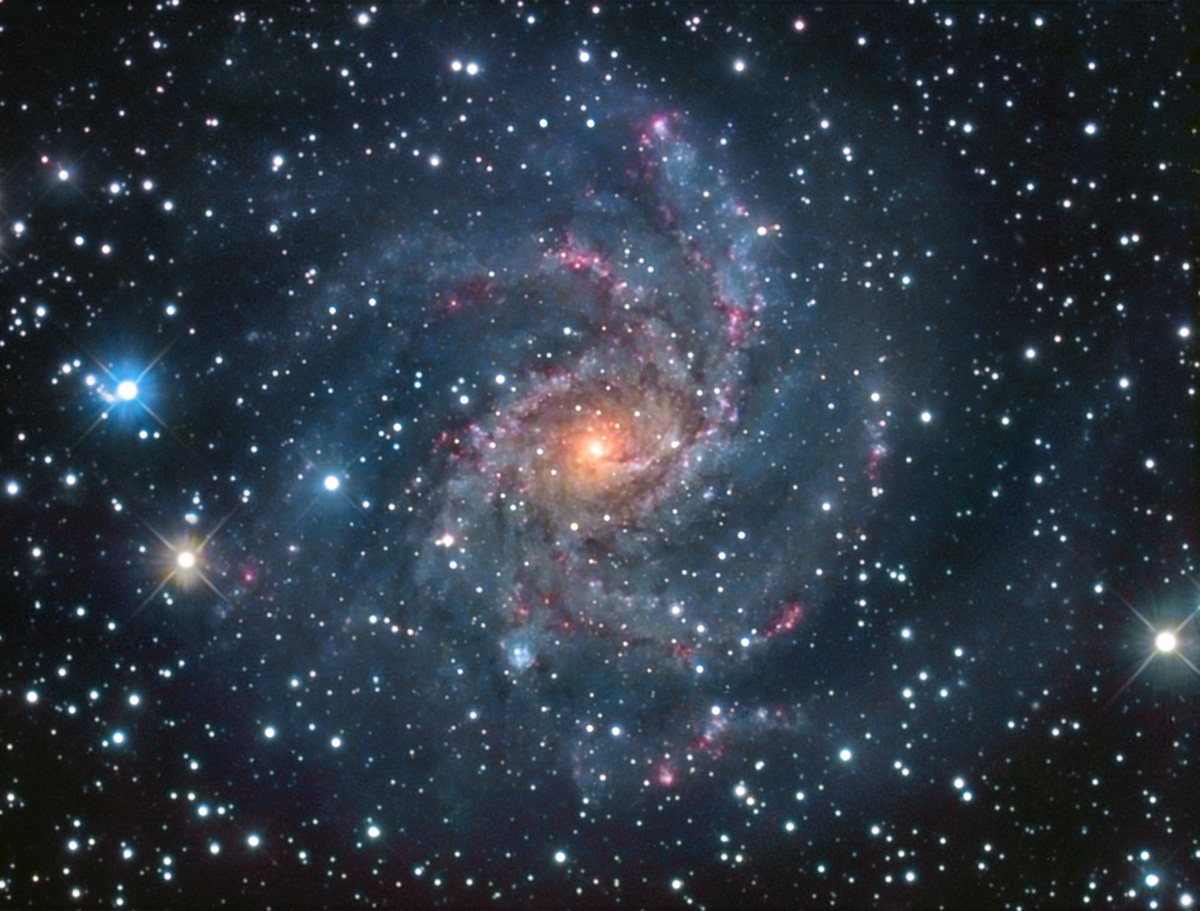
This code will be helpful for your photometry project, so make sure you understand what is going on!

First, we will import useful programs.  We used matplotlib last class to plot, but the rest of these might look new.  Astropy has a bunch of useful programs for astronomy. We will be using 'fits' to read our images in the fits format, and the units, wcs, and coordinates package to create variables in the form of astronomy units (there are some pretty nifty conversions between coordinate systems you can do with these programs!).  Photutils is a package created to do photometry, so it will be useful for your projects, and numpy is a math-y python program that is useful if you are doing any kind of number-related stuff (logs, averages, line fitting, numpy has it all)!

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

For folks who don't have photutils working (for whatever reason, likely not your fault!), I've put together a little code to do aperture photometry without phot_utils.  It has some flaws, but will work for now at least!

In [2]:
def ap_phot(x,y,rad,data):
    sum = 0.0
    r = int(rad)+1
    i = x - 2*rad -1.
    j = y - 2*rad
    while (i <= x+2*r):
        j = y - 2*rad
        i = i + 1
        while (j <= y+2*r):
            if(np.sqrt((x-i)**2+(y-j)**2) <= r):
                sum = sum + data[int(i)][int(j)]
                j = j + 1.0
            else:
                sum = sum
                j = j + 1.0
    return sum

This function needs the x,y pixel location of the center of your aperture (where you want to get data), and the radius of your aperture in pixels.  Then, if you just stick in your data, it should give you the same output as photutils aperture_photometry package.

Now, let's load a 24 micron and FUV image of NGC6946.  The 24 micron image was taken with the MIPs instrument on Spitzer and the FUV image was part of the Nearby Galaxy Survey with Galex.

We will load the data using the fits.open() command.  Once we open each file, we can store the image data by telling python we want the information from the zero-th extension in your fits image.  Sometimes, fits files will have multiple extensions with the errors or weighting used in the image.  For us, we will only ever need the first extension.

In [3]:
mips_file = 'ngc6946_mips24_image_v5-0.fits'
galex_file = 'UVX_NGC6946-fd-int.fits'
hdu_24 = fits.open(mips_file)
hdu_fuv = fits.open(galex_file)
m_data = hdu_24[0].data
f_data = hdu_fuv[0].data

Just so we can get a bit of an idea of what we are working with, let's plot the data from both galaxies.  We can do this using the imshow() function of matplotlib.pyplot.  Our data is already stored in an array that has brightness values per position, so it is already in the right formate for this function.  You can also view them with ds9 if you would prefer.  You'll notice I've changed the color scale using the 'norm' option on imshow.  This just helps us distinguish the important differences in images with a wide range of variation.

/Users/jessicasutter/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


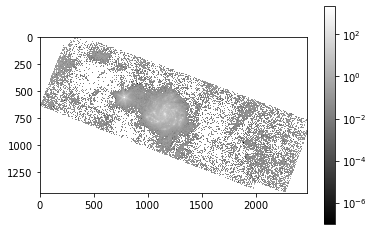

In [4]:
from matplotlib import colors
plt.imshow(m_data, cmap='gray', norm=colors.LogNorm())
plt.colorbar()

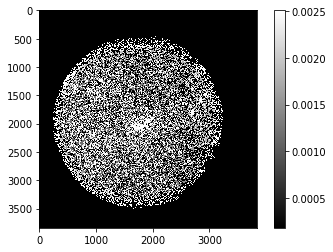

In [6]:
normlizer = colors.Normalize(vmin = 0.00018, vmax = 0.00251) 
plt.imshow(f_data, cmap='gray', norm=normlizer)
plt.colorbar()

I've gone ahead and done aperature photometry on the nucleus in the FUV image.  I did this by creating a SkyCoord object cetered on the center of NGC6946 (RA = 308.718, Dec = 69.15360), then extracting the flux within a 10 arcsec region around this point using SkyCircularAperature and aperture_photometry.  I also needed to tell the aperature_photometry program which pixels coresponded to the RA and Dec of the center of NGC6946, so I used the wcs program to read the header of my image and grab the necessary info to match the x/y positions on the image to a position on the sky.  

In [13]:
f_nuc = SkyCoord(308.718, 60.15360, unit='deg', frame='icrs')
wcs = WCS(hdu_fuv[0].header)
f_nuc_pix = skycoord_to_pixel(f_nuc, wcs, origin=0, mode='all')
fuv_counts = ap_phot(f_nuc_pix[0], f_nuc_pix[1], 509, f_data)
print(fuv_counts)
#f_aperture = SkyCircularAperture(f_nuc, r=10.0 * u.arcsec)
#f_phot_table = aperture_photometry(f_data, f_aperture, wcs = wcs)


1404.5311539063696


Finally, we need to convert or units to something that makes more sense.  GALEX images have units of 'counts/pixel', or number of times a photon hit the CCD onboard.  We want to convert to erg/s for our SFR calculation.  I've also added some comments to explain what I am doing in each step using the '#' symbol to denote a comment, or something the python code will ignore.

In [8]:
D = 6.80 #Distance to NGC6946 in Mpc 
lamfuv = 1528 #Wavelength of the GALEX FUV band in Angstroms
zpfuv = 18.82 #Zeropoint for magnitude calculation for GALEX counts
conv = 3630.78 #Conversion factor for GALEX FUV images
radius_pix = 10.0 * 1.5 #1.5 pixels/arcsec, GALEX plate scale
flux_fuv = fuv_counts * np.pi * radius_pix**2 #conversion from counts/pixel to counts
flux_fuv = flux_fuv * conv*10**(-zpfuv/2.5) #conversion from counts to jy
Lum_fuv = flux_fuv*1E-23*4.0*np.pi*(D*3.0857E24)**2*(3E18/lamfuv) #conversion from Jy to erg/s
Lum_fuv = Lum_fuv
print(Lum_fuv)

2.4013249376708134e+42


Now it's your turn!  Extract the flux from the 10 arcsec aperature around the nucleus of NGC6946 in the Mips 24 micron image.  The mips image is in units of MJy/sr, so you will need to do some unit conversions here to get to Luminosity in erg/s.

In [11]:
wcs = WCS(hdu_24[0].header)
m_nuc_pix = skycoord_to_pixel(f_nuc, wcs, origin=0, mode='all')
mips_counts = ap_phot(m_nuc_pix[1], m_nuc_pix[0], 10.0/1.3, m_data)
print(mips_counts)
mips_flux = mips_counts * np.pi * (10./206265.)**2 #multiply by area in SR to get MJy
Lum_mips = mips_flux*1E-20*4.0*np.pi*(D*3.0857E24)**2*(3E14/24.0) #conversion from MJy to erg/s
print(Lum_mips)

73071.20737457275
3.7315578365204925e+41


Once you have found your 24 micron flux in erg/s, you can find the SFR using the equations from the Kennicutt & Evans annual review, Tables 1 & 2.  Compare the SFR you get when you only use FUV to the SFR you get when both are included.  Why are they different?  Which do you think is more accurate?  Why?

In [10]:
LUV_Corr = Lum_fuv + 3.89*Lum_mips
logSFR = np.log10(LUV_Corr) - 43.35
SFR = 10**logSFR
print(SFR)
SFR_nocorr = 10**(np.log10(Lum_fuv)-43.35)
print(SFR_nocorr)

0.17210276303288097
0.10726324490804826
